This example shows how to perform GP regression, but using **variational inference** rather than exact inference. There are a few cases where variational inference may be prefereable:

1) If you have lots of data, and want to perform **stochastic optimization**

2) If you have a model where you want to use other variational distributions

In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
# Create a training set
# We're going to learn a sine function
train_x = torch.linspace(0, 1, 1000)
train_y = torch.sin(train_x * (4 * math.pi)) + torch.randn(train_x.size()) * 0.2

## Performing SGD - the dataloader

Because we want to do stochastic optimization, we have to put the dataset in a pytorch **DataLoader**.
This creates easy minibatches of the data

In [3]:
from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

## The model

This is pretty similar to a normal regression model, except now we're using a `gpytorch.models.GridInducingVariationalGP` instead of a `gpytorch.models.ExactGP`.

Any of the variational models would work. We're using the `GridInducingVariationalGP` because we have many data points, but only 1 dimensional data.

Similar to exact regression, we use a `GaussianLikelihood`.

In [4]:
class GPRegressionModel(gpytorch.models.GridInducingVariationalGP):
    def __init__(self):
        super(GPRegressionModel, self).__init__(grid_size=64, grid_bounds=[(-0.05, 1.05)])
        self.mean_module = gpytorch.means.ConstantMean(constant_bounds=[-1e-5,1e-5])
        self.covar_module = gpytorch.kernels.RBFKernel(log_lengthscale_bounds=(-5, 6))
        self.register_parameter('log_outputscale', torch.nn.Parameter(torch.Tensor([0])), bounds=(-5,6))
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        covar_x = covar_x.mul(self.log_outputscale.exp())
        return gpytorch.random_variables.GaussianRandomVariable(mean_x, covar_x)
    
model = GPRegressionModel().cuda()
likelihood = gpytorch.likelihoods.GaussianLikelihood().cuda()

## The training loop

This training loop will use **stochastic optimization** rather than batch optimization

In [5]:
model.train()
likelihood.train()

# We'll do 40 iterations of optimization
n_iter = 40

# We use SGD here, rather than Adam
# Emperically, we find that SGD is better for variational regression
optimizer = torch.optim.SGD([
    {'params': model.parameters()},
    {'params': likelihood.parameters()},
], lr=0.1)

# We use a Learning rate scheduler from PyTorch to lower the learning rate during optimization
# We're going to drop the learning rate by 1/10 after 3/4 of training
# This helps the model converge to a minimum
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[0.75 * n_iter], gamma=0.1)

# Our loss object
# We're using the VariationalMarginalLogLikelihood object
mll = gpytorch.mlls.VariationalMarginalLogLikelihood(likelihood, model, n_data=train_y.size(0))

# The training loop
def train():
    for i in range(n_iter):
        scheduler.step()
        
        # Within each iteration, we will go over each minibatch of data
        for x_batch, y_batch in train_loader:
            x_batch = torch.autograd.Variable(x_batch.float().cuda())
            y_batch = torch.autograd.Variable(y_batch.float().cuda())
            optimizer.zero_grad()
            
            # We're going to use two context managers here
            
            # The use_toeplitz flag makes learning faster on the GPU
            # See the DKL-MNIST notebook for an explanation
            
            # The diagonal_correction flag improves the approximations we're making for variational inference
            # It makes running time a bit slower, but improves the optimization and predictions
            with gpytorch.settings.use_toeplitz(False), gpytorch.beta_features.diagonal_correction():
                output = model(x_batch)
                loss = -mll(output, y_batch)
                print('Iter %d/%d - Loss: %.3f (%.3f)' % (i + 1, n_iter, loss.data[0], optimizer.param_groups[0]['lr']))
            
            # The actual optimization step
            loss.backward()
            optimizer.step()
            
%time train()

Iter 1/40 - Loss: 387.373 (0.100)
Iter 1/40 - Loss: 1.319 (0.100)
Iter 1/40 - Loss: 5.413 (0.100)
Iter 1/40 - Loss: 1.339 (0.100)
Iter 1/40 - Loss: 2.537 (0.100)
Iter 1/40 - Loss: 1.402 (0.100)
Iter 1/40 - Loss: 1.340 (0.100)
Iter 1/40 - Loss: 2.036 (0.100)
Iter 1/40 - Loss: 1.454 (0.100)
Iter 1/40 - Loss: 1.359 (0.100)
Iter 1/40 - Loss: 1.780 (0.100)
Iter 1/40 - Loss: 1.519 (0.100)
Iter 1/40 - Loss: 1.403 (0.100)
Iter 1/40 - Loss: 1.336 (0.100)
Iter 1/40 - Loss: 1.582 (0.100)
Iter 1/40 - Loss: 1.342 (0.100)
Iter 2/40 - Loss: 1.375 (0.100)
Iter 2/40 - Loss: 1.357 (0.100)
Iter 2/40 - Loss: 1.252 (0.100)
Iter 2/40 - Loss: 1.349 (0.100)
Iter 2/40 - Loss: 1.260 (0.100)
Iter 2/40 - Loss: 1.392 (0.100)
Iter 2/40 - Loss: 1.484 (0.100)
Iter 2/40 - Loss: 1.312 (0.100)
Iter 2/40 - Loss: 1.378 (0.100)
Iter 2/40 - Loss: 1.363 (0.100)
Iter 2/40 - Loss: 1.336 (0.100)
Iter 2/40 - Loss: 1.455 (0.100)
Iter 2/40 - Loss: 1.322 (0.100)
Iter 2/40 - Loss: 1.278 (0.100)
Iter 2/40 - Loss: 1.257 (0.100)
Iter 2

Iter 17/40 - Loss: 0.136 (0.100)
Iter 17/40 - Loss: 0.170 (0.100)
Iter 17/40 - Loss: 0.160 (0.100)
Iter 17/40 - Loss: 0.236 (0.100)
Iter 18/40 - Loss: 0.269 (0.100)
Iter 18/40 - Loss: 0.124 (0.100)
Iter 18/40 - Loss: 0.024 (0.100)
Iter 18/40 - Loss: 0.126 (0.100)
Iter 18/40 - Loss: 0.183 (0.100)
Iter 18/40 - Loss: 0.080 (0.100)
Iter 18/40 - Loss: 0.174 (0.100)
Iter 18/40 - Loss: 0.076 (0.100)
Iter 18/40 - Loss: 0.082 (0.100)
Iter 18/40 - Loss: 0.058 (0.100)
Iter 18/40 - Loss: 0.062 (0.100)
Iter 18/40 - Loss: 0.224 (0.100)
Iter 18/40 - Loss: 0.180 (0.100)
Iter 18/40 - Loss: 0.074 (0.100)
Iter 18/40 - Loss: 0.042 (0.100)
Iter 18/40 - Loss: 0.284 (0.100)
Iter 19/40 - Loss: 0.162 (0.100)
Iter 19/40 - Loss: 0.084 (0.100)
Iter 19/40 - Loss: 0.074 (0.100)
Iter 19/40 - Loss: 0.103 (0.100)
Iter 19/40 - Loss: 0.069 (0.100)
Iter 19/40 - Loss: 0.101 (0.100)
Iter 19/40 - Loss: 0.057 (0.100)
Iter 19/40 - Loss: -0.007 (0.100)
Iter 19/40 - Loss: 0.205 (0.100)
Iter 19/40 - Loss: 0.156 (0.100)
Iter 19/4

Iter 33/40 - Loss: 0.026 (0.010)
Iter 33/40 - Loss: 0.026 (0.010)
Iter 33/40 - Loss: 0.101 (0.010)
Iter 33/40 - Loss: 0.007 (0.010)
Iter 33/40 - Loss: 0.076 (0.010)
Iter 33/40 - Loss: 0.024 (0.010)
Iter 33/40 - Loss: 0.172 (0.010)
Iter 33/40 - Loss: 0.018 (0.010)
Iter 33/40 - Loss: 0.102 (0.010)
Iter 34/40 - Loss: 0.137 (0.010)
Iter 34/40 - Loss: 0.232 (0.010)
Iter 34/40 - Loss: 0.047 (0.010)
Iter 34/40 - Loss: -0.042 (0.010)
Iter 34/40 - Loss: 0.172 (0.010)
Iter 34/40 - Loss: -0.018 (0.010)
Iter 34/40 - Loss: -0.021 (0.010)
Iter 34/40 - Loss: 0.055 (0.010)
Iter 34/40 - Loss: 0.144 (0.010)
Iter 34/40 - Loss: 0.090 (0.010)
Iter 34/40 - Loss: 0.014 (0.010)
Iter 34/40 - Loss: 0.106 (0.010)
Iter 34/40 - Loss: 0.087 (0.010)
Iter 34/40 - Loss: 0.040 (0.010)
Iter 34/40 - Loss: -0.033 (0.010)
Iter 34/40 - Loss: 0.136 (0.010)
Iter 35/40 - Loss: 0.010 (0.010)
Iter 35/40 - Loss: 0.129 (0.010)
Iter 35/40 - Loss: -0.054 (0.010)
Iter 35/40 - Loss: -0.094 (0.010)
Iter 35/40 - Loss: 0.264 (0.010)
Iter

## Testing the model

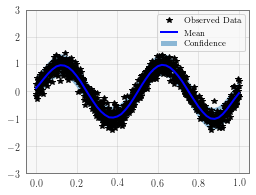

In [6]:
model.eval()
likelihood.eval()

test_x = torch.autograd.Variable(torch.linspace(0, 1, 51)).cuda()
with gpytorch.settings.max_cg_iterations(2000), gpytorch.settings.use_toeplitz(False), gpytorch.beta_features.diagonal_correction():
    observed_pred = likelihood(model(test_x))

lower, upper = observed_pred.confidence_region()
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.plot(train_x.cpu().numpy(), train_y.cpu().numpy(), 'k*')
ax.plot(test_x.data.cpu().numpy(), observed_pred.mean().data.cpu().numpy(), 'b')
ax.fill_between(test_x.data.cpu().numpy(), lower.data.cpu().numpy(), upper.data.cpu().numpy(), alpha=0.5)
ax.set_ylim([-3, 3])
ax.legend(['Observed Data', 'Mean', 'Confidence'])